## ResNet, Deep Residual Learning for Image Recognition

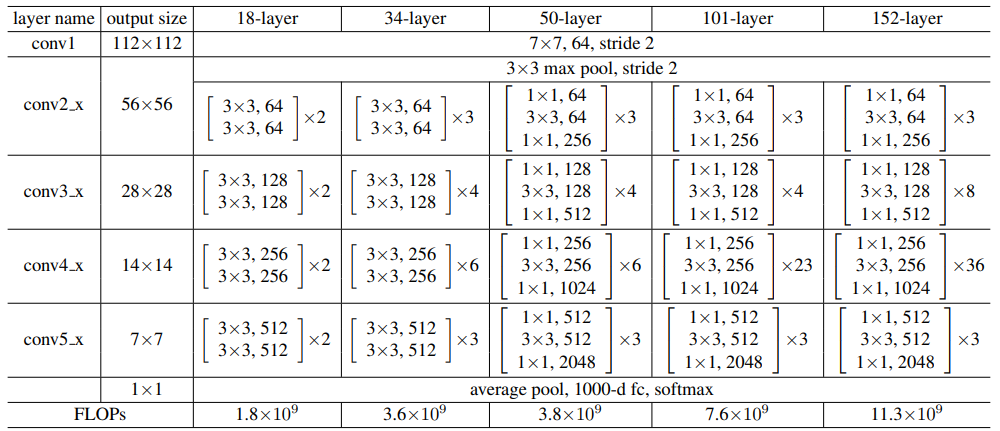

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, dataloader
import random
import numpy as np


In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [40]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1,norm=True, relu=True):
        super().__init__()

        layer = []

        layer.append(nn.Conv2d(
            in_channels=in_channel,
            out_channels=out_channel,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            relu=relu
        ))

        if norm:
            layer.append(nn.BatchNorm2d(out_channel))
        if relu:
            layer.append(nn.ReLU())

        self.convb = nn.Sequential(*layer)

    def forward(self, x):
        return self.convb(x)
        

In [41]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1,short_cut=False):
        super().__init__()

        self.resb1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel,
                out_channels=out_channel,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
                ),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
                ),
            nn.BatchNorm2d(out_channel)
        )

        self.relu = nn.ReLU()
        
        self.resb2 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel,
                out_channels=out_channel,
                kernel_size=kernel_size,
                stride=2,
                padding=padding
                ),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
                ),
            nn.BatchNorm2d(out_channel)
        )

        self.shortcut = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel,
                out_channels=out_channel,
                kernel_size=kernel_size,
                stride=2,
                padding=padding
            )
        )
        

    def forward(self, x, short_cut=False):
        if short_cut:
            return self.relu(self.resb2(x) + self.shortcut(x))
        else:
            return self.relu(self.resb1(x) + x)

In [42]:
class ResNet18(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv1 = nn.Conv2d(3,64,kernel_size=7, stride=2, padding=3)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = ResBlock(64,64,kernel_size=kernel_size,stride=stride,padding=padding)

        self.conv3_1 = ResBlock(64,128,kernel_size=kernel_size,stride=stride,padding=padding)
        self.conv3_2 = ResBlock(128,128,kernel_size=kernel_size,stride=stride,padding=padding)

        self.conv4_1 = ResBlock(128,256,kernel_size=kernel_size,stride=stride,padding=padding)
        self.conv4_2 = ResBlock(256,256,kernel_size=kernel_size,stride=stride,padding=padding)

        self.conv5_1 = ResBlock(256,512,kernel_size=kernel_size,stride=stride,padding=padding)
        self.conv5_2 = ResBlock(512,512,kernel_size=kernel_size,stride=stride,padding=padding)

        self.avg_pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(512,10)

    def forward(self, x):
        
        x = self.conv1(x)
        print(x.size())
        x = self.max_pool(x)
        print(x.size())

        x = self.conv2(x)
        x = self.conv2(x)
        print(x.size())

        x = self.conv3_1(x, short_cut=True)
        x = self.conv3_2(x)
        print(x.size())

        x = self.conv4_1(x, short_cut=True)
        x = self.conv4_2(x)
        print(x.size())

        x = self.conv5_1(x, short_cut=True)
        x = self.conv5_2(x)
        print(x.size())

        x = self.avg_pooling(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)

        return x

In [47]:
model_test = ResNet18(3,64)
x = torch.randn((4,3,224,224))
out = model_test(x)

torch.Size([4, 64, 112, 112])
torch.Size([4, 64, 56, 56])
torch.Size([4, 64, 56, 56])
torch.Size([4, 128, 28, 28])
torch.Size([4, 256, 14, 14])
torch.Size([4, 512, 7, 7])


In [45]:
from torchsummary import summary
summary(model_test, (3,224,224))

torch.Size([2, 64, 112, 112])
torch.Size([2, 64, 56, 56])
torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28])
torch.Size([2, 256, 14, 14])
torch.Size([2, 512, 7, 7])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 64, 56, 56]          36,928
       BatchNorm2d-4           [-1, 64, 56, 56]             128
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,928
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
          ResBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             